In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np

In [2]:
class ConvNet2(nn.Module):
    def __init__(self):
        super(ConvNet2, self).__init__()
        self.conv1 = nn.Conv2d(2, 1, kernel_size=2,padding=1)
        self.conv2 = nn.ConvTranspose2d(1, 3, kernel_size=2, stride=6, padding=1)
        self.bn1 = nn.BatchNorm2d(1)
        self.bn2 = nn.BatchNorm2d(3)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.conv2(x)
        x = self.bn2(x)
        return x

In [3]:
model=ConvNet2()
##CNN Architecture (batch_size, channels, height, width)

In [4]:
try_input=torch.tensor([[[0.,0.],[6.,0.]],[[0.,6.],[6.,6.]]])

In [5]:
try_input.size()

torch.Size([2, 2, 2])

In [6]:
input=try_input.unsqueeze(0)

In [7]:
model(input).size()

torch.Size([1, 3, 12, 12])

In [8]:
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/data"
os.chdir(path)
train_data=xr.open_dataset("train_data_stationnary.nc")

In [9]:
train_data

<xarray.Dataset>
Dimensions:  (week: 312, rlat: 101, rlon: 176)
Coordinates:
  * week     (week) int32 12 27 50 20 20 24 48 51 45 ... 5 25 12 10 30 48 52 11
    year     (week) int32 ...
  * rlon     (rlon) float32 -3.0 -2.98 -2.96 -2.94 -2.92 ... 0.44 0.46 0.48 0.5
  * rlat     (rlat) float32 -1.0 -0.98 -0.96 -0.94 -0.92 ... 0.94 0.96 0.98 1.0
Data variables:
    TOT_PR   (week, rlat, rlon) float32 ...

In [10]:
rlat = torch.tensor(train_data['rlat'].values)
rlat=rlat[0:96]
rlon=torch.tensor(train_data['rlon'].values)
rlon=rlon[0:174]
grid_lat, grid_lon = torch.meshgrid(rlat, rlon)
tensor_resolution_2km = torch.stack((grid_lat, grid_lon), dim=-1)
tensor_resolution_12km = tensor_resolution_2km[::6, ::6, :]
tensor_resolution_12km.size()

/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/dev_env/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3483.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


torch.Size([16, 29, 2])

In [100]:
##Defining the training set
path = "/work/FAC/FGSE/IDYST/tbeucler/downscaling/mberthier/repos/Downscaling_CM/utils"
os.chdir(path)
import training_set

In [101]:
class CustomCRPSLoss(nn.Module):
    def __init__(self):
        super(CustomCRPSLoss, self).__init__()

    def forward(self, y_pred, y_true):
        term_one = torch.mean(torch.abs(y_pred - y_true), dim=-1)
        term_two = torch.mean(torch.abs(
        torch.unsqueeze(y_pred, -1) - torch.unsqueeze(y_pred, -2)), dim=(-2, -1))
        half = torch.tensor(-0.5, dtype=term_two.dtype)
        loss = term_one + half * term_two
        loss = torch.mean(loss)
        return loss

In [102]:
batch = train_data.isel(week=slice(1,5))
train_data=train_data.isel(rlon=slice(0,174),rlat=slice(0,96))
train_data

<xarray.Dataset>
Dimensions:  (week: 312, rlat: 96, rlon: 174)
Coordinates:
  * week     (week) int32 12 27 50 20 20 24 48 51 45 ... 5 25 12 10 30 48 52 11
    year     (week) int32 ...
  * rlon     (rlon) float32 -3.0 -2.98 -2.96 -2.94 -2.92 ... 0.4 0.42 0.44 0.46
  * rlat     (rlat) float32 -1.0 -0.98 -0.96 -0.94 -0.92 ... 0.84 0.86 0.88 0.9
Data variables:
    TOT_PR   (week, rlat, rlon) float32 ...

Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan
Epoch [5/5], Loss: nan


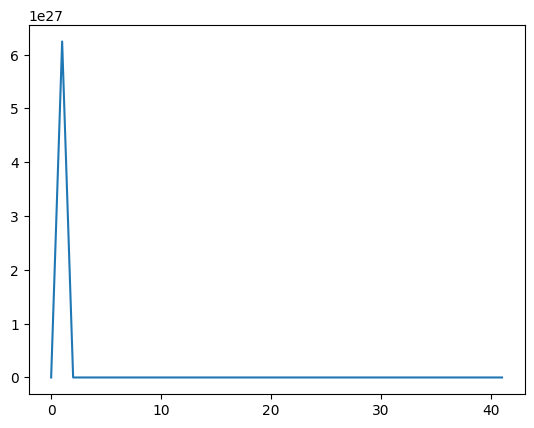

In [103]:
num_weeks = len(train_data['week'])
num_epoch=5
batch_size_train=20
train_len=num_weeks
nb_lon= len(train_data['rlon'])
nb_lat= len(train_data['rlat'])

optimizer= torch.optim.Adam(model.parameters(), lr=0.01)
loss_crps=CustomCRPSLoss()
loss_list=[]
for epoch in range(num_epoch):
    for j in range(0,train_len-batch_size_train,batch_size_train):
        batch = train_data.isel(week=slice(j,j+batch_size_train))
        batch_output=training_set.training_set_output(batch)
        #print(batch_output.size())
        #il faut transformer l'input qui est de taille [batch,101,176,2] en [batch,2,101,176]
        input_prepared=tensor_resolution_12km.unsqueeze(0)
        input_prepared=input_prepared.permute(0, 3, 1, 2)

        outputs=model(input_prepared)
        #print(outputs.size())
        #print(outputs[:,:,10:20,5:10])
    
        loc, scale, c = outputs[:,0,:,:],outputs[:,1,:,:],outputs[:,2,:,:]
    
        size = (nb_lon*nb_lat,batch_output.shape[2])
        loc=loc.flatten()
        scale=scale.flatten()
        c=c.flatten()
        loc = loc.unsqueeze(1)
        scale = scale.unsqueeze(1)
        c = c.unsqueeze(1)
        #print('taille loc, scale et c', loc.size(),scale.size(),c.size())
        
        u = torch.rand(size)
        #print(scale)
        echantillons = loc + (torch.pow(-torch.log(u), -c) - 1) * scale / c
        #print(echantillons.size())
        true_echant=torch.reshape(batch_output,(nb_lon*nb_lat,batch_output.shape[2]))
        #print(true_echant.size())

        #echantillons = echantillons.requires_grad_(True)
        true_echant =true_echant.requires_grad_(True)        
        loss=loss_crps(echantillons,true_echant)
        
        loss_list.append(torch.detach(loss).numpy())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (epoch+1) % 5 == 0:
            print(f'Epoch [{epoch+1}/{num_epoch}], Loss: {loss.item():.4f}')

plt.plot(loss_list)
plt.show()
    

In [104]:
##en input il faut une carte ! pas comme LNN où il faut (lon,lat)
#nous on veut faire du downscaling donc renvoyer une image de meilleure résolution ! 